# Yemen NTL Trends

1. Pull and process NTL imagery for all of Yemen, from January 2021 through latest available. 
2. Create 2 line charts, tracking monthly percent change (or other normalized index) of NTL by admin-level 1 (governorate), with markers for the period from 4/2022 to 10/2022, and another chart, with just two lines, for aggregated North (Houthis) and South (IRG) admin-1s. 
3. Prepare a table with the raw data, that the team can use for further analysis and indexing. 

In [1]:
import os, sys
from os.path import join, expanduser
from gadm import GADMDownloader
import ee
import geopandas as gpd
import pandas as pd
from gee_zonal import ZonalStats, gee_helpers
from glob import glob

In [2]:
# ee.Authenticate()
# sys.path.append(join(expanduser('~'), 'Repos_45VFZW2', 'GEE_Zonal', 'src'))
# from gee_zonal import ZonalStats, gee_helpers

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format, percent_format, comma_format
import plotnine
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import folium as flm

## Admin Boundaries

<Axes: >

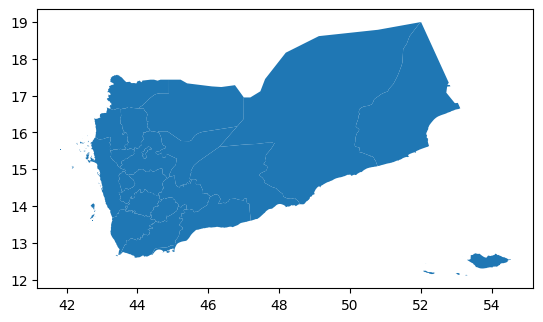

In [4]:
downloader = GADMDownloader(version="4.0")
country_name = "Yemen"
ad_level = 1
gadm1 = downloader.get_shape_data_by_country_name(country_name=country_name, ad_level=ad_level)
gadm1.plot()

## NTL Data

In [5]:
start = "2018-01-01"
end = "2023-05-01"

### Check for cloud cover

In [6]:
coverage = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG").select('cf_cvg').filterDate(start, end)

def getGT0(image):
    return image.gt(0).clip(aoi).set('system:time_start', image.get('system:time_start'))
def getGTE0(image):
    return image.gte(0).clip(aoi).set('system:time_start', image.get('system:time_start'))

aoi = gee_helpers.gpd_to_gee(gadm1)

coverage_gt0 = coverage.map(getGT0)
coverage_gte0 = coverage.map(getGTE0)

zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG',
    target_features = aoi,
    statistic_type = 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = coverage_gt0
)
res = zs.runZonalStats()
df_gt0 = res.copy()

zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG',
    target_features = aoi,
    statistic_type = 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = coverage_gte0
)
res = zs.runZonalStats()
df_gte0 = res.copy()

cols_cf = ['cf' in col for col in df_gt0.columns]
cols = list(~pd.Series(cols_cf))
df_pct = df_gt0.iloc[:, cols].join(df_gt0.loc[:, cols_cf].divide(df_gte0.loc[:, cols_cf]))
def rename_func(col):
    if "cf_cvg" in col:
        p = col.split("_")
        new_name = "pct"+"__"+p[0]
        return(new_name)
    else:
        return col
df_pct.rename(rename_func, axis=1, inplace=True)
df_pct_re = pd.wide_to_long(
    df_pct,
    stubnames = ['pct'],
    i = 'NAME_1',
    j = 'date',
    sep = "__"
)
df_pct_re.reset_index(inplace=True)
df_pct_re.loc[:,"ym"] = pd.to_datetime(df_pct_re.date, format="%Y%m%d")

In [7]:
plotnine.options.figure_size = (12, 12)

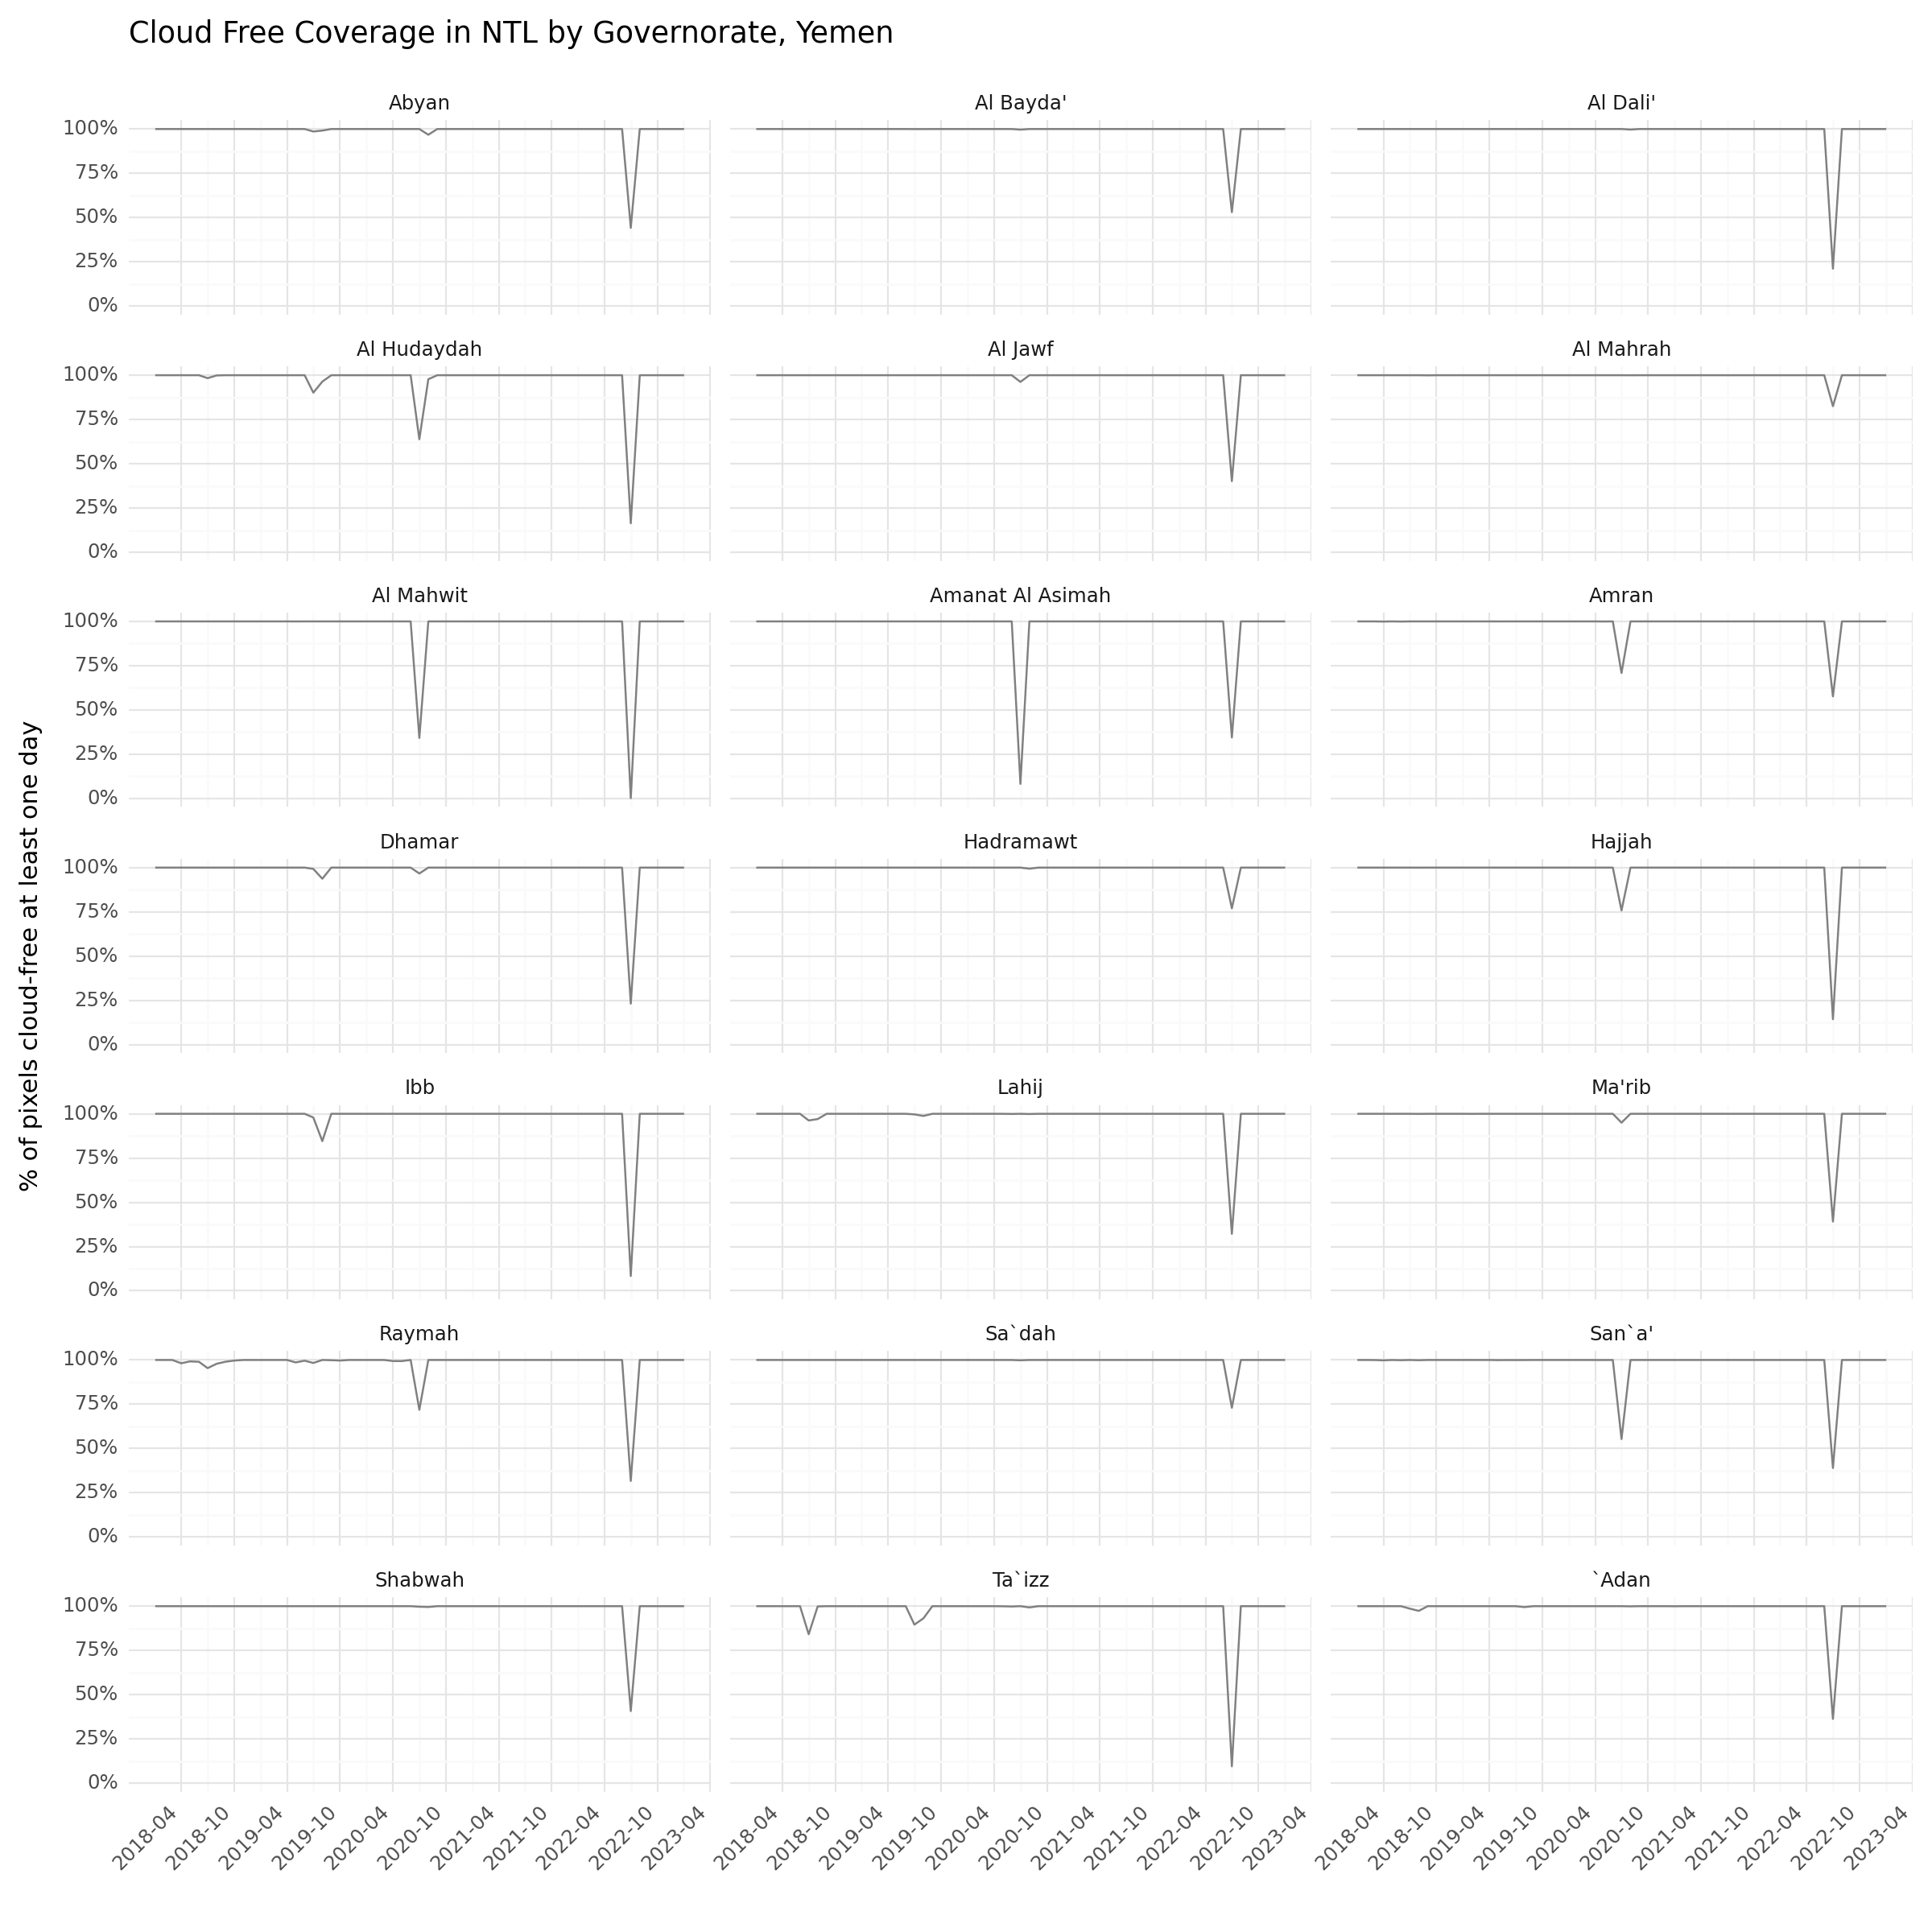

<Figure Size: (1200 x 1200)>

In [8]:
plot = (
ggplot(df_pct_re, aes(x="ym", y="pct", group="NAME_1")) #
    + geom_line(alpha=1, color="gray")
    + labs(
        x="", y="% of pixels cloud-free at least one day", title="Cloud Free Coverage in NTL by Governorate, Yemen",
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('6 months'), labels=date_format('%Y-%m'))
    + scale_y_continuous(labels=percent_format())
    + theme(legend_position='bottom')
    + facet_wrap("~NAME_1", scales = "fixed", ncol=3)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
plot

### Interpolate pixels with missing data due to clouds

In [9]:
def smoothenViirs(collection, window_size):

    def prepareImage(img):
        rad = img.select('avg_rad')
        cf_cvg = img.select('cf_cvg')
        cf_eq0 = cf_cvg.gt(0)
        img_masked = rad.mask(cf_eq0)

        date = img.date()
        # add a time variable
        months = date.difference(ee.Date('1970-01-01'), 'month')
        return img_masked.addBands(ee.Image(months).rename('time')).float()

    def smoother(t):
        # helper function to apply linear regression equation
        def applyFit(img):
            return img.select('time').multiply(fit.select('scale')) \
                    .add(fit.select('offset')) \
                    .set('system:time_start',img.get('system:time_start')) \
                    .rename('avg_rad')
        
        t = ee.Date(t)
        
        window = data.filterDate(t.advance(-window_size,'month'),t.advance(window_size,'month'))
        
        fit = window.select(['time','avg_rad']) \
            .reduce(ee.Reducer.linearFit())
        
        return window.map(applyFit).toList(10)
    
    # function to reduce time stacked linear regression results
    # requires that a variable 'fitIC' exists from the smoother function
    def reduceFits(t):
        t = ee.Date(t)
        return fitIC.filterDate(t.advance(-window_size,'month'),t.advance(window_size,'month')) \
                  .mean().set('system:time_start',t.millis()).rename('avg_rad')
    
    def replace(original):
        date = original.date()
        smoothed_sel = smoothed.filterDate(date, date.advance(1, 'day'))
        smooth = smoothed_sel.first()
        return smooth.where(original, original)
    
    data = collection \
        .map(prepareImage)
    
    # get unique dates
    dates = ee.List(data.aggregate_array('system:time_start'))
    
    fitIC = ee.ImageCollection(dates.map(smoother).flatten())
    
    smoothed = ee.ImageCollection(dates.map(reduceFits))
    
    collection_fill = data.select('avg_rad').map(replace)
    return collection_fill

In [10]:
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG").select('avg_rad').filterDate(start, end) # VCMSLCFG
viirs_copy = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG").filterDate(start, end)
viirs_interpolated = smoothenViirs(viirs_copy, 3)

In [11]:
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
    target_features = aoi,
    statistic_type= 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = viirs
)
res = zs.runZonalStats()
df_ee = res.copy()

def rename_func(col):
    if "avg_rad" in col:
        p = col.split("_")
        if len(p)>1:
            new_name = "rad"+"__"+p[0]
            return(new_name)
        else:
            return col
    else:
        return col
df_ee.rename(rename_func, axis=1, inplace=True)
df_ee = pd.wide_to_long(
    df_ee,
    stubnames = ['rad'],
    i = 'NAME_1',
    j = 'date',
    sep = "__"
)
df_ee.reset_index(inplace=True)
df_ee.loc[:,"ym"] = pd.to_datetime(df_ee.date, format="%Y%m%d")

In [12]:
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
    target_features = aoi,
    statistic_type= 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = viirs_interpolated
)
res = zs.runZonalStats()
df_ee_int = res.copy()

def rename_func(col):
    if "avg_rad" in col:
        p = col.split("_")
        if len(p)>1:
            new_name = "rad"+"__"+p[0]
            return(new_name)
        else:
            return col
    else:
        return col
df_ee_int.rename(rename_func, axis=1, inplace=True)
df_ee_int = pd.wide_to_long(
    df_ee_int,
    stubnames = ['rad'],
    i = 'NAME_1',
    j = 'date',
    sep = "__"
)
df_ee_int.reset_index(inplace=True)
df_ee_int.loc[:,"ym"] = pd.to_datetime(df_ee_int.date, format="%Y%m%d")

In [13]:
df_ee_int.rename(columns={"rad":"rad_int"}, inplace=True)

In [14]:
df = df_ee.merge(df_ee_int[['NAME_1', 'ym', 'rad_int']], on=['NAME_1', 'ym'], how='left', validate='1:1')

In [15]:
df.loc[:, "month"] = df.ym.dt.month
df.loc[:, "year"] = df.ym.dt.year

In [16]:
data_dir = join(expanduser("~"), 'data')
output_dir = join(expanduser("~"), 'output', 'yem')

In [17]:
df.head()

,NAME_1,date,HASC_1,ID_0,ENGTYPE_1,ISO_1,NL_NAME_1,CC_1,TYPE_1,ID_1,VARNAME_1,COUNTRY,rad,ym,rad_int,month,year
0,`Adan,20180101,YE.AD,YEM,Governorate,,عدن,24,Muhafazah,YEM.1_1,Aden,Yemen,11760.768553,2018-01-01,11526.664663,1,2018
1,Abyan,20180101,YE.AB,YEM,Governorate,,أبين,12,Muhafazah,YEM.2_1,,Yemen,7814.861088,2018-01-01,7756.142594,1,2018
2,Al Bayda',20180101,YE.BA,YEM,Governorate,,البيضاء,14,Muhafazah,YEM.3_1,Albaidah|Al Baidha|Al-Baydha|Al Beida|Baidaa|A...,Yemen,3051.297134,2018-01-01,3075.272802,1,2018
3,Al Dali',20180101,YE.DL,YEM,Governorate,,الضالع,30,Muhafazah,YEM.4_1,Al Dhale'e,Yemen,1900.279527,2018-01-01,1902.250158,1,2018
4,Al Hudaydah,20180101,YE.HU,YEM,Governorate,,الحديده,18,Muhafazah,YEM.5_1,Al Hodeida|Al-Hodeidah|Al Hudaidah|Hodiedah|Hu...,Yemen,9720.596979,2018-01-01,9940.506484,1,2018


In [18]:
df.to_csv(join(output_dir, 'adm1_viirs_ee.csv'), index=False)

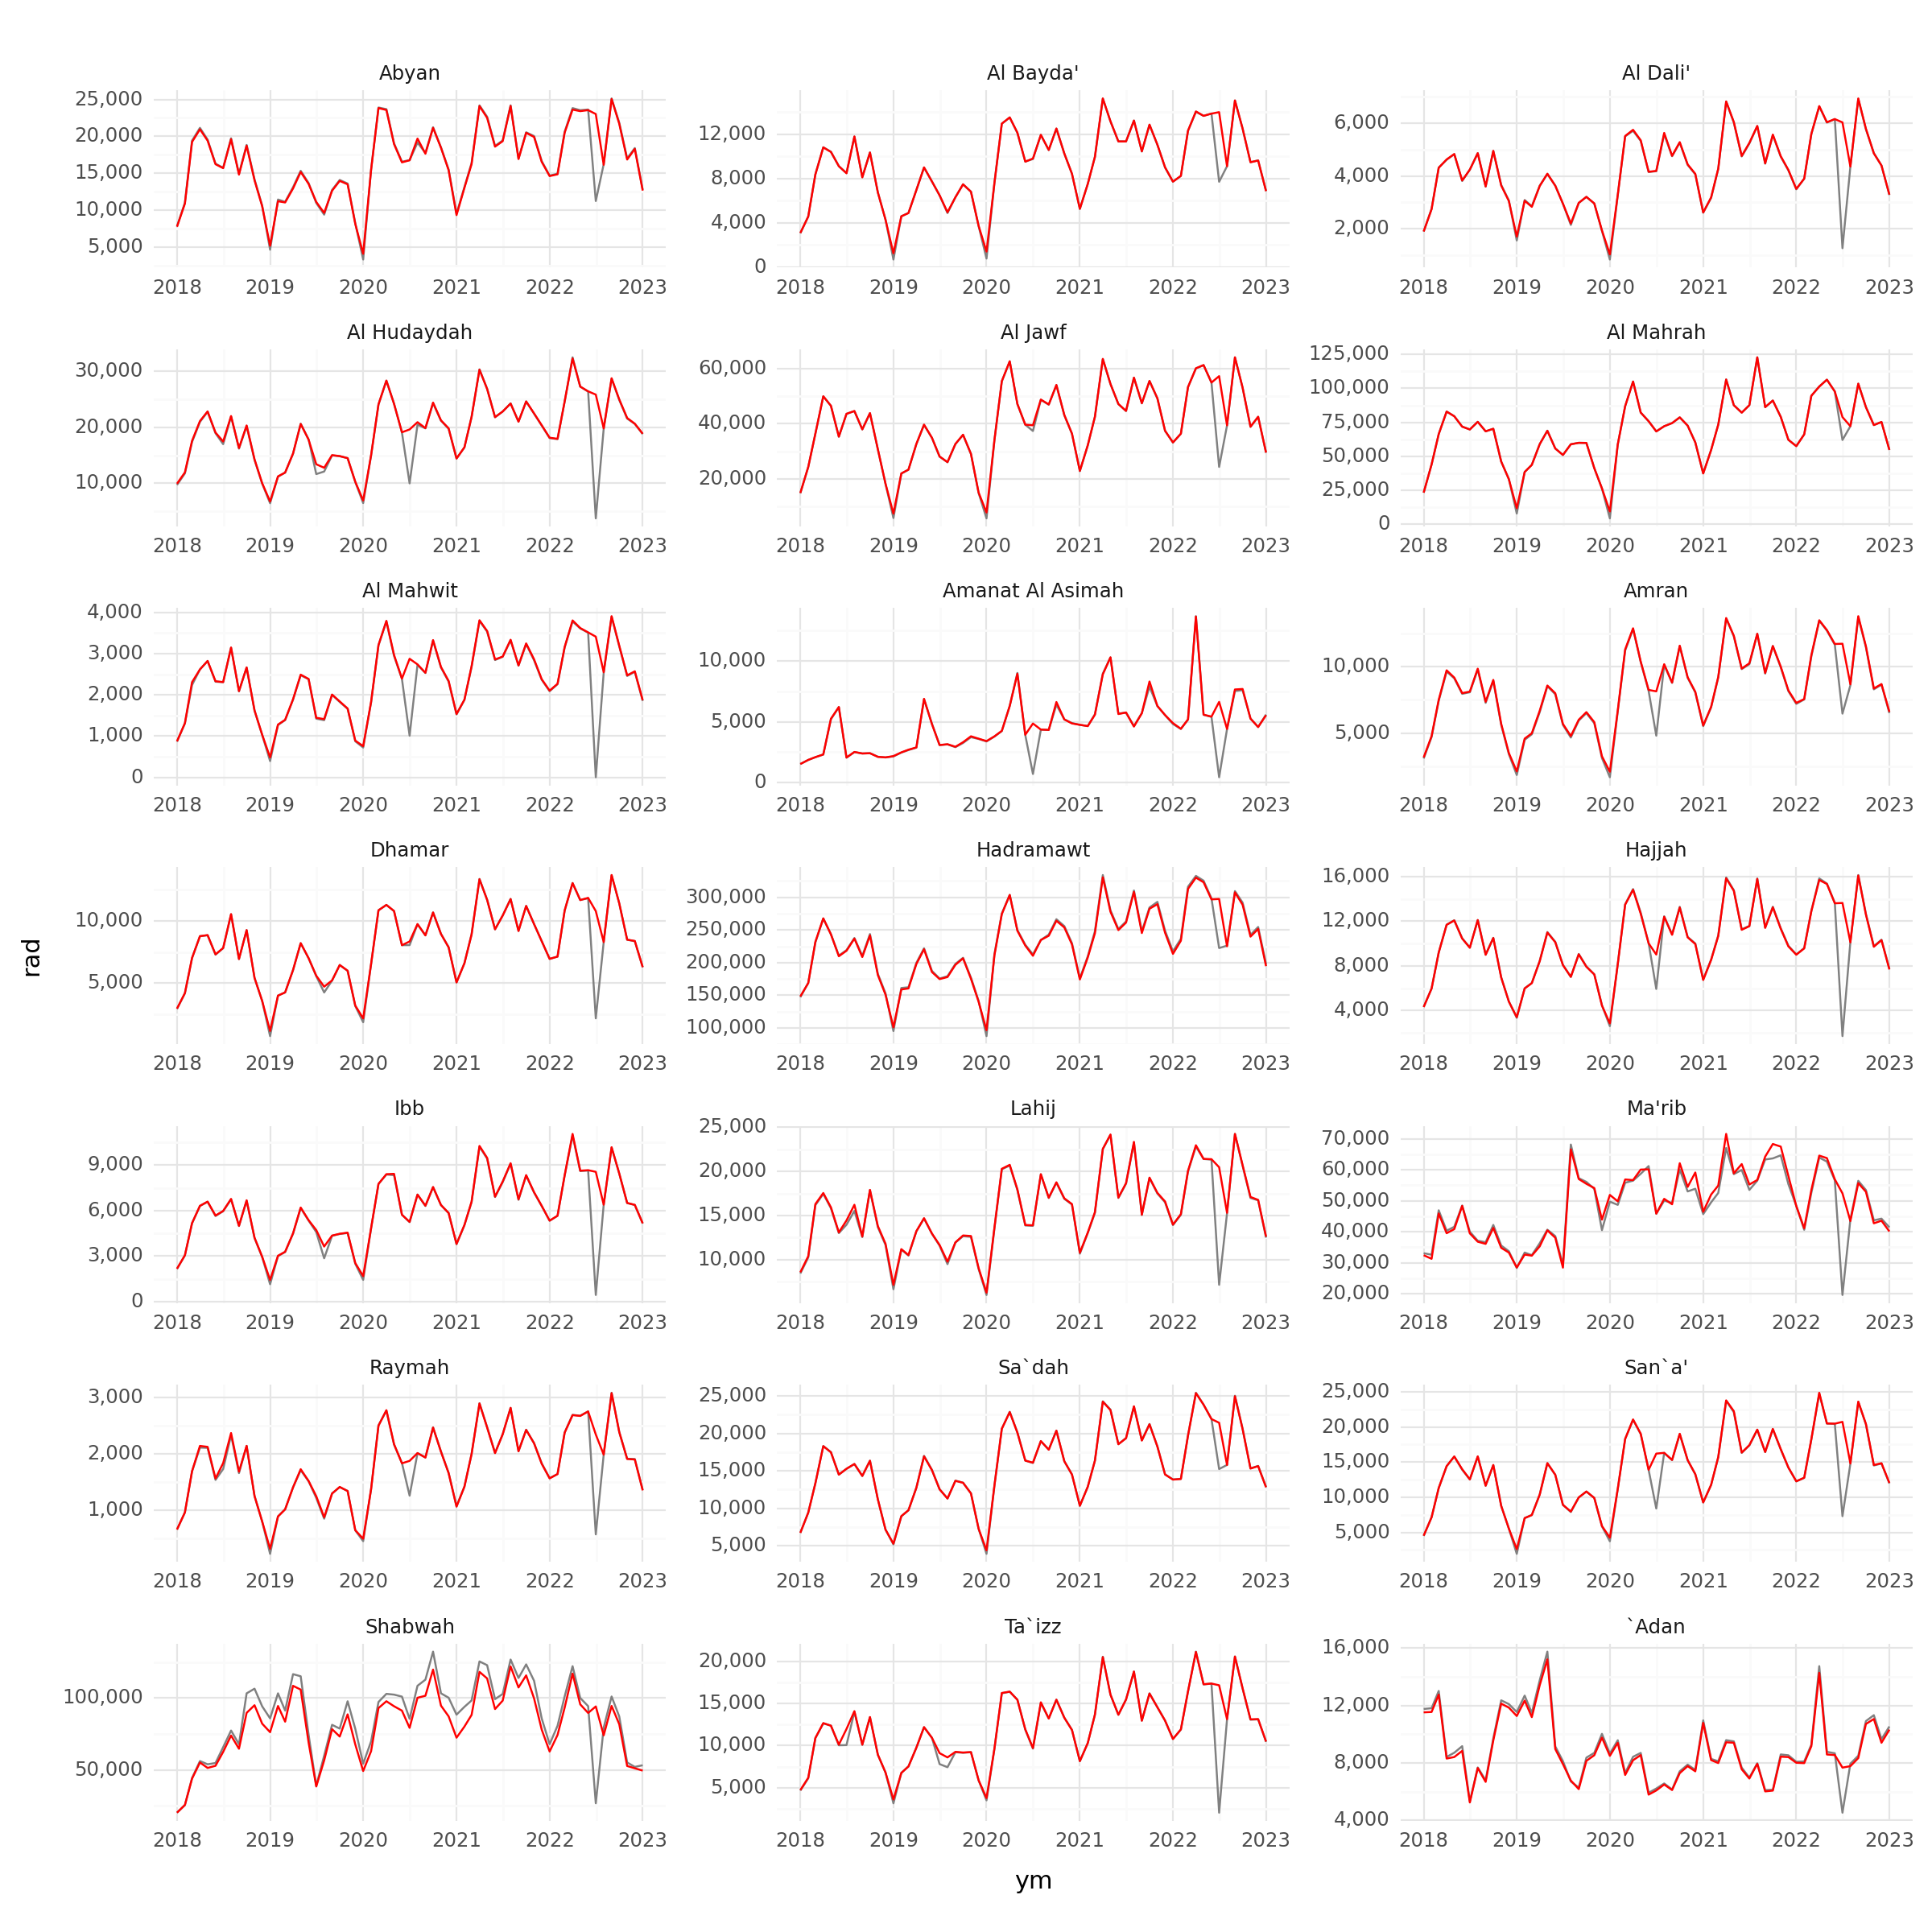

<Figure Size: (1200 x 1200)>

In [19]:
(
ggplot(df, aes(x="ym", y="rad", group="NAME_1")) #
    + geom_line(alpha=1, color="gray")
    + geom_line(aes(x="ym", y="rad_int", group="NAME_1"), color="red")
    # + labs(
    #     x="", y="% of pop", title="Population Access to Health Facilities by Wealth Quintile",
    #     fill="Within 2 h
    # )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('1 year'), labels=date_format('%Y'))
    + scale_y_continuous(labels=comma_format())
    # + scale_y_continuous(labels=percent_format())
    + theme(legend_position='bottom')
    + facet_wrap("~NAME_1", scales = "free", ncol=3)
)

## Calculate reference values

In [41]:
def calculate_ref(period):
    if period==2021:
        df_ref = df.loc[df.year==2021,:].copy()
    else:
        df_ref = df.loc[df.year<2022,:].copy()
    
    df_ref = df_ref.groupby(["NAME_1", "month"])[['rad', 'rad_int']].mean().reset_index()
    df_ref.rename(columns={"rad":"rad_ref", "rad_int":"rad_int_ref"}, inplace=True)

    df_filt = df.merge(df_ref, on=["NAME_1", "month"], how="left", validate="m:1")
    df_filt = df_filt.loc[df_filt.ym>="2022-01-01",:].copy()
    df_filt.loc[:, "rad_int_pct"] = df_filt.rad_int / df_filt.rad_int_ref
    df_filt.loc[:, "rad_int_pct_ch"] = df_filt.apply(lambda x: (x.rad_int-x.rad_int_ref) / (x.rad_int_ref), axis=1)
    df_filt.loc[:, "direction"] = ""
    df_filt.loc[df_filt.rad_int_pct_ch<0, "direction"] = "decrease"
    df_filt.loc[df_filt.rad_int_pct_ch>0, "direction"] = "increase"

    return df_filt

In [46]:
df_historical_baseline = calculate_ref('historical')
df_2021_baseline = calculate_ref(2021)

In [27]:
# ref_period = 2021 # 2021 or all previous
# if ref_period==2021:
#     df_ref = df.loc[df.year==2021,:].copy()
# else:
#     df_ref = df.loc[df.year<2022,:].copy()

In [28]:
# df_ref = df_ref.groupby(["NAME_1", "month"])[['rad', 'rad_int']].mean().reset_index()
# df_ref.rename(columns={"rad":"rad_ref", "rad_int":"rad_int_ref"}, inplace=True)
# df_filt = df.merge(df_ref, on=["NAME_1", "month"], how="left", validate="m:1")
# df_filt = df_filt.loc[df_filt.ym>="2022-01-01",:].copy()
# df_filt.loc[:, "rad_int_pct"] = df_filt.rad_int / df_filt.rad_int_ref
# df_filt.loc[:, "rad_int_pct_ch"] = df_filt.apply(lambda x: (x.rad_int-x.rad_int_ref) / (x.rad_int_ref), axis=1)
# df_filt.loc[:, "direction"] = ""
# df_filt.loc[df_filt.rad_int_pct_ch<0, "direction"] = "decrease"
# df_filt.loc[df_filt.rad_int_pct_ch>0, "direction"] = "increase"


## Graphs

## Pct. Change from baseline

In [54]:
p1 = (
ggplot(df_historical_baseline, aes(x="ym", y="rad_int_pct_ch", group="NAME_1", fill="direction")) #
    + geom_col(alpha=0.7, color="black", width=15)
    # + geom_hline(yintercept=0)
    + geom_vline(xintercept="2022-04-01", linetype="dashed", color = "gray")
    + geom_vline(xintercept="2022-10-01", linetype="dashed", color = "gray")
    + labs(
        x="", y="", title="NTL by Governorate, Yemen", subtitle="% Change in sum of lights from monthly baseline (2018-2021)",
        caption="Source: VIIRS (Earth Observation Group)"
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('1 month'), labels=date_format('%Y, %m'))
    + scale_y_continuous(labels=percent_format())
    + theme(legend_position='none')
    + facet_wrap("~NAME_1", scales = "fixed", ncol=3)
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(12, 12))
    + scale_fill_manual(values=['#d73027', '#1a9850'])
    # + scale_fill_brewer(type="div", palette="RdYlGn", name="Change in NTL", direction=1)
    # + scale_fill_distiller(type="div", palette="RdYlGn", name="Change in NTL", direction=1, limits=(-1, 1))
)
p1.save(filename=join(output_dir, 'adm1-pct-change-historical.jpeg'), dpi=300)

/home/jupyter-wb514197/.conda/envs/earth/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 12 x 12 in image.
/home/jupyter-wb514197/.conda/envs/earth/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/jupyter-wb514197/output/yem/adm1-pct-change-historical.jpeg


In [56]:
p2 = (
ggplot(df_2021_baseline, aes(x="ym", y="rad_int_pct_ch", group="NAME_1", fill="direction")) #
    + geom_col(alpha=0.7, color="black", width=15)
    + geom_vline(xintercept="2022-04-01", linetype="dashed", color = "gray")
    + geom_vline(xintercept="2022-10-01", linetype="dashed", color = "gray")
    + labs(
        x="", y="", title="NTL by Governorate, Yemen", subtitle="% Change in sum of lights from previous month (2021)",
        caption="Source: VIIRS (Earth Observation Group)"
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('1 month'), labels=date_format('%Y, %m'))
    + scale_y_continuous(labels=percent_format())
    + theme(legend_position='none')
    + facet_wrap("~NAME_1", scales = "fixed", ncol=3)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + scale_fill_manual(values=['#d73027', '#1a9850'])
    # + scale_fill_brewer(type="div", palette="RdYlGn", name="Change in NTL", direction=1)
    # + scale_fill_distiller(type="div", palette="RdYlGn", name="Change in NTL", direction=1, limits=(-1, 1))
)
p2.save(filename=join(output_dir, 'adm1-pct-change-2021.jpeg'), dpi=300)

/home/jupyter-wb514197/.conda/envs/earth/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 12 x 12 in image.
/home/jupyter-wb514197/.conda/envs/earth/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/jupyter-wb514197/output/yem/adm1-pct-change-2021.jpeg


In [57]:
p3 = (
ggplot(df.loc[df.year>=2021], aes(x="ym", y="rad_int", group="NAME_1")) #
    + geom_line(alpha=1)
    # + geom_line(aes(x="ym", y="rad_int_ref", group="NAME_1"), alpha=0.5, color="red")
    # + geom_hline(yintercept=0)
    + geom_vline(xintercept="2022-04-01", linetype="dashed", color = "gray")
    + geom_vline(xintercept="2022-10-01", linetype="dashed", color = "gray")
    + labs(
        x="", y="", title="NTL by Governorate, Yemen", subtitle="Sum of Lights",
        caption="Source: VIIRS (Earth Observation Group)"
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('2 months'), labels=date_format('%y, %m'))
    + scale_y_continuous(labels=comma_format())
    + theme(legend_position='bottom')
    + facet_wrap("~NAME_1", scales = "free", ncol=3)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    # + scale_color_manual(values=['#d73027', '#1a9850'], labels=['True', 'Monthly Reference'])
    # + scale_fill_brewer(type="div", palette="RdYlGn", name="Change in NTL", direction=1)
    # + scale_fill_distiller(type="div", palette="RdYlGn", name="Change in NTL", direction=1, limits=(-1, 1))
)
p3.save(filename=join(output_dir, 'adm1-lights.jpeg'), dpi=300)

/home/jupyter-wb514197/.conda/envs/earth/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 12 x 12 in image.
/home/jupyter-wb514197/.conda/envs/earth/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/jupyter-wb514197/output/yem/adm1-lights.jpeg


In [70]:
# df_both = pd.melt(
#     df_filt[['NAME_1', 'ym', 'rad_int', 'rad_int_ref']],
#     id_vars = ['NAME_1', 'ym'],
#     value_vars = ['rad_int', 'rad_int_ref'],
#     value_name = 'rad',
#     var_name = 'type'
# )

In [69]:
# p3 = (
# ggplot(df_both, aes(x="ym", y="rad", group="type", color='type')) #
#     + geom_line(alpha=1)
#     # + geom_line(aes(x="ym", y="rad_int_ref", group="NAME_1"), alpha=0.5, color="red")
#     # + geom_hline(yintercept=0)
#     + geom_vline(xintercept="2022-04-01", linetype="dashed", color = "gray")
#     + geom_vline(xintercept="2022-10-01", linetype="dashed", color = "gray")
#     + labs(
#         x="", y="", title="NTL by Governorate, Yemen", subtitle="Sum of Lights, VIIRS"
#     )
#     + theme_minimal() 
#     + scale_x_datetime(breaks=date_breaks('2 months'), labels=date_format('%y, %m'))
#     + scale_y_continuous(labels=comma_format())
#     + theme(legend_position='bottom')
#     + facet_wrap("~NAME_1", scales = "free", ncol=3)
#     + theme(axis_text_x=element_text(rotation=45, hjust=1))
#     + scale_color_manual(values=['#d73027', '#1a9850'], labels=['True', 'Monthly Reference'])
#     # + scale_fill_brewer(type="div", palette="RdYlGn", name="Change in NTL", direction=1)
#     # + scale_fill_distiller(type="div", palette="RdYlGn", name="Change in NTL", direction=1, limits=(-1, 1))
# )
# p3